In [8]:
!wget https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/raw/main/notebooks/utils.py

--2023-05-15 03:17:12--  https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/raw/main/notebooks/utils.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py [following]
--2023-05-15 03:17:13--  https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-05-15 03:17:13 (47.4 MB/s) - ‘utils.py’ saved [7

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

from utils import display, sample_batch

In [1]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 3
CRITIC_STEPS = 3
GP_WEIGHT = 10.0

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sayandafadar
Your Kaggle Key: ··········


100%|██████████| 1.33G/1.33G [00:16<00:00, 88.2MB/s]


In [5]:
train_data = keras.utils.image_dataset_from_directory(
    "/content/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode='rgb',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

Found 202599 files belonging to 1 classes.


In [6]:
def preprocess(img):
  img = (tf.cast(img, tf.float32) - 127.5) / 127.5
  return img

train = train_data.map(lambda img: preprocess(img))
train = train.prefetch(tf.data.AUTOTUNE)

In [10]:
train_sample = sample_batch(train)

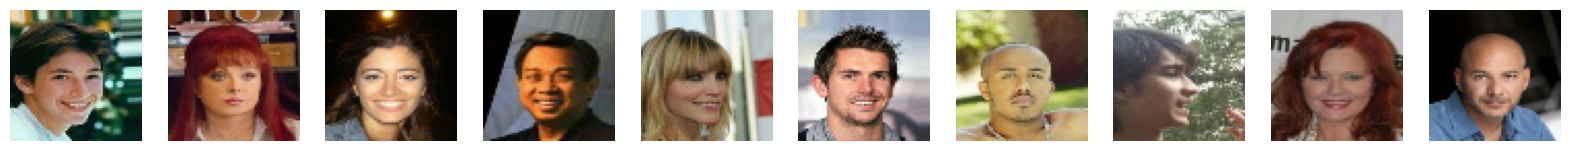

In [11]:
display(train_sample)

## Critic

In [12]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, (4, 4), strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, (4, 4), strides=2, padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, (4, 4), strides=2, padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(1, (4, 4), padding='valid')(x)
critic_output = layers.Flatten()(x)
critic = keras.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

## Generator

In [13]:
generator_input = layers.Input(shape=(Z_DIM))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, (4, 4), padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, (4, 4), strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, (4, 4), strides=2, padding='same', activation='tanh')(x)
generator = keras.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        1048576   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [28]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

In [29]:
class WGANGP(models.Model):
  def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
    super(WGANGP, self).__init__()
    self.critic = critic
    self.generator = generator
    self.latent_dim = latent_dim
    self.critic_steps = critic_steps
    self.gp_weight = gp_weight

  def compile(self, c_optimizer, g_optimizer):
    super(WGANGP, self).compile()
    self.c_optimizer = c_optimizer
    self.g_optimizer = g_optimizer
    self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
    self.c_gp_metric = metrics.Mean(name="c_gp")
    self.c_loss_metric = metrics.Mean(name="c_loss")
    self.g_loss_metric = metrics.Mean(name="g_loss")

  @property
  def metrics(self):
    return [
        self.c_loss_metric,
        self.c_wass_loss_metric,
        self.c_gp_metric,
        self.g_loss_metric
    ]

  def gradient_penalty(self, batch_size, real_images, fake_images):
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolated)
      pred = self.critic(interpolated, training=True)

    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]

    for i in range(self.critic_steps):
      random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

      with tf.GradientTape() as tape:
        fake_images = self.generator(random_latent_vectors, training=True)
        fake_predictions = self.critic(fake_images, training=True)
        real_predictions = self.critic(real_images, training=True)

        c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
        c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
        c_loss = c_wass_loss + c_gp * self.gp_weight

      c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
      self.c_optimizer.apply_gradients(zip(c_gradient, self.trainable_variables))

    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    
    with tf.GradientTape() as tape:
      fake_images = self.generator(random_latent_vectors, training=True)
      fake_predictions = self.critic(fake_images, training=True)
      g_loss = -tf.reduce_mean(fake_predictions)

    gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
    self.c_loss_metric.update_state(c_loss)
    self.c_wass_loss_metric.update_state(c_wass_loss)
    self.c_gp_metric.update_state(c_gp)
    self.g_loss_metric.update_state(g_loss)

    return {m.name: m.result() for m in self.metrics}

In [30]:
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=3,
    gp_weight=GP_WEIGHT
)

In [31]:
# Compile the GAN
wgangp.compile(
    c_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2)
)

In [32]:
class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            cmap=None,
        )

396/396 [==============================] - ETA: 0s - c_loss: -21.7902 - c_wass_loss: -29.2331 - c_gp: 0.7443 - g_loss: -17.8112

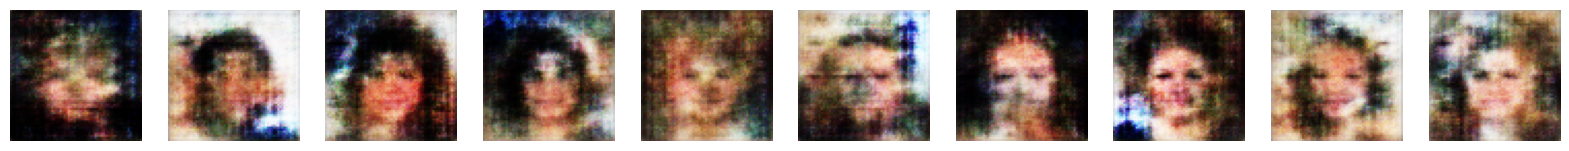

396/396 [==============================] - 872s 2s/step - c_loss: -21.7902 - c_wass_loss: -29.2331 - c_gp: 0.7443 - g_loss: -17.8112


In [33]:
history = wgangp.fit(train,
           epochs=1,
           callbacks=[ImageGenerator(num_img=10, latent_dim=Z_DIM)])